In [1]:
import pandas as pd

df = pd.read_csv("logs2.csv.gz", parse_dates=[1])

In [2]:
df.dtypes

ogpweb#               int64
date         datetime64[ns]
request              object
code                  int64
bytes                 int64
referrer             object
useragent            object
source               object
rt                  float64
urt                 float64
dtype: object

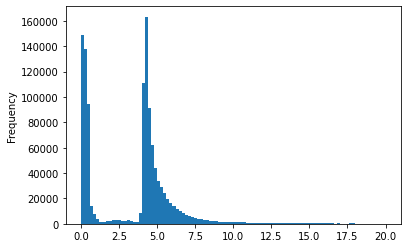

In [48]:
ax = df['urt'].plot.hist(bins=100, range=[0,20])

In [6]:
def bucket(r):
    r = r.rsplit('HTTP/')[0].split('GET ')[-1]
    for s in ('?', '/dataset/', '/reference/', '/inventory/',
              '/comment/', '/node/', '/suggested-datasets/',
              '/4plan/', '/apps/'):
        if s in r:
            r = r.split(s)[0] + s + '…'
    return r
bdf = df[['request','urt']].copy(deep=True)
bdf['request'] = bdf['request'].map(bucket)

In [11]:
day_budget = 4 * 8 * 2
day_budget

64

In [33]:
sdf = bdf.groupby(['request']).agg(['median','count','sum'])
sdf.columns = sdf.columns.map('_'.join)
sdf['urt_sum'] = sdf['urt_sum'] / (60*60*24)  # days

busy = sdf[(sdf['urt_count'] > 10) & (sdf['urt_sum'] > 0.02)]
busy.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (days)'})

,urt_median,urt_count,urt_sum (days)
request,,,
/fr/search/travelq?…,4.4930,620529,37.555687
/fr/search/contrats?…,5.8720,36149,2.901315
/en/search/travelq?…,4.7770,36571,2.251064
/en/search/reclassification?…,4.5850,23679,1.424887
/data/en/dataset?…,0.4020,173048,0.823992
/en/search/ati?…,0.1410,11602,0.218162
/fr/search/travela?…,4.4740,3196,0.175357
/en?…,2.1010,4176,0.121397
/data/en/dataset/…,0.1550,49969,0.117959


In [29]:
urt_sum_sum = sdf['urt_sum'].sum()
urt_sum_sum # days

46.99050006944476

In [44]:
dsearch_sum = bdf[bdf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days" % (dsearch_sum))
print("%0.2f %% urt" % (dsearch_sum / urt_sum_sum * 100))

44.85 days
95.44 % urt


In [13]:
df['search'] = df['urt'].notna() & df['request'].str.contains(r'/(?:od|bn|ct|ei|gc|nap|si|qp|sd)/')
df['ckan'] = df['urt'].notna() & df['request'].str.contains(' /data/')
df['drupal'] = df['urt'].notna() & ~ df['search'] & ~ df['ckan']

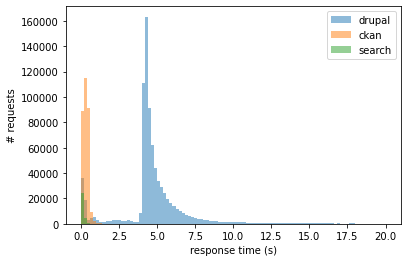

In [49]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['urt'], alpha=0.5, bins=100, range=[0,20],  label='drupal')
ax.hist(df[df['ckan']]['urt'], alpha=0.5, bins=100, range=[0,20],  label='ckan')
ax.hist(df[df['search']]['urt'], alpha=0.5, bins=100, range=[0,20], label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
ax.set_xlabel('response time (s)')
plt.show()

In [15]:
cadf = df[df['request'].str.contains('/action/')][
    ['request','urt']].copy(deep=True)
cadf['request'] = cadf['request'].str.extract(r'/action/(\w+)')

In [16]:
scadf = cadf.groupby(['request']).agg(['median','count','sum'])
scadf.columns = scadf.columns.map('_'.join)
scadf['urt_sum'] = scadf['urt_sum'] / 60  # minutes
scadf.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (minutes)'})

,urt_median,urt_count,urt_sum (minutes)
request,,,
package_show,0.042,6667,4.991067
organization_list,6.326,45,4.787300
package_update,2.366,33,1.438800
package_search,0.344,110,0.875183
package_list,1.523,10,0.341133
recently_changed_packages_activity_list,0.153,12,0.030767
help_show,0.014,1,0.000233


In [17]:
import heapq
from datetime import datetime, timedelta

def csim(expire):
    h = []
    c = set()
    def lookup(row):
        dt = row['date']
        req = row['request']
        while h and h[0][0] + expire < dt:
            c.remove(h[0][1])
            heapq.heappop(h)
        if req in c:
            return True
        heapq.heappush(h, (dt, req))
        c.add(req)
        return False
    return lookup

In [20]:
cdf = df[df['urt'].notna() & df['request'].str.match('GET ')][
    ['ogpweb#','date','request','urt']].copy(deep=True)
cdf.sort_values(by='date', inplace=True)

In [19]:
#cdf['1dhit'] = cdf.apply(csim(timedelta(days=1)), axis=1)

In [21]:
#s = cdf[cdf['1dhit']][['urt']].sum()
#print("%0.2f hours" % (s / 60 / 60))
#print("%0.2f %% savings" % (s / 60 / 60 / 24 / days_budget * 100))

In [22]:
cdf['5mhit'] = cdf.apply(csim(timedelta(minutes=5)), axis=1)

In [25]:
s = cdf[cdf['5mhit']][['urt']].sum()
print("%0.2f hours" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / urt_sum_sum * 100))

3.73 hours
0.33 % savings


In [26]:
#cdf[(cdf['date'] > datetime(2020,9,4,1,1,1)) &
#    (cdf['date'] < datetime(2020,9,4,1,1,10))]

In [71]:
#df['tod'] = df['date'].apply(lambda x: x.timestamp())
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots()
#ax.hist(df[df['ogpweb#'] == 1]['tod'], alpha=0.5, bins=100, label='1')
#ax.hist(df[df['ogpweb#'] == 2]['tod'], alpha=0.5, bins=100, label='2')
#ax.hist(df[df['ogpweb#'] == 3]['tod'], alpha=0.5, bins=100, label='3')
#ax.hist(df[df['ogpweb#'] == 4]['tod'], alpha=0.5, bins=100, label='4')
#plt.show()